# **Regresión no lineal**

### **Base de datos:** TiempoDeEntrega.csv

1. Importa los datos del archivo “Tiempo de entrega.csv” a tu ambiente de trabajo. Este archivo lo encontrarás en la misma página donde descargaste esta plantilla. Genera una gráfica de dispersión que muestre el comportamiento de los datos. Agrega una línea de texto en la que generes una predicción sobre qué tipo de algoritmo será el más adecuado para resolver la tarea (no hay respuestas correctas).

In [17]:
pip install mlinsights

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 31.2 MB/s eta 0:00:00


In [29]:
#Importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import pwlf
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.neighbors import KNeighborsRegressor as KNN

In [7]:
#Leer CSV
url = 'https://raw.githubusercontent.com/AdrianaPS03/A1.6-TiempoDeEntrega/refs/heads/main/TiempoDeEntrega.csv'
df = pd.read_csv(url)

Durante el proceso se encontró (mirando más a detalle el archivo csv) que dentro de la base de datoshay filas que contienen valores tales como 'NA', conjuntos de símbolos que no hacen mucho sentido como '$#%', y un total de 11 líneas con solo comas. Esto podría estar causando problemas a la hora de gráficar los datos, por lo que se eliminaron del archivo manualmente, resolviendo así el problema con la gráficación de datos.

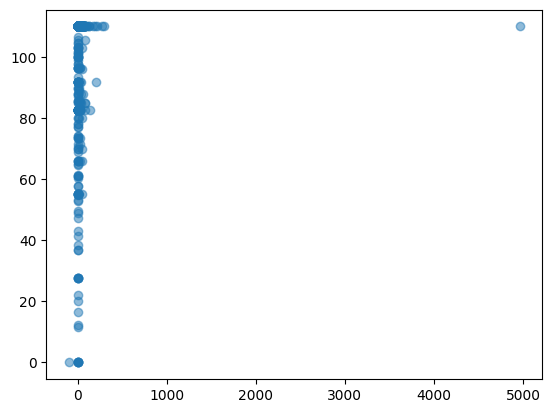

In [8]:
plt.scatter(df['Tiempo'], df['Calificacion'], alpha=0.5)

Al gráficar los puntos se encontró también que es probable que haya valores que puedan ser considerados outliers dentro de la base de datos. A continuación se realizará un análisis de estos para comprobar si son o no son outliers.

In [9]:
# Outliers para Tiempo
q1 = df.Tiempo.quantile(0.25)
q3 = df.Tiempo.quantile(0.75)
# Rango intercuartil
iqr = q3 - q1
# Límite inferior
li = q1 - (3 * iqr)
# Límite superior
ls = q3 + (3 * iqr)
# Observaciones fuera de cualquiera de los dos límites por k = 3
out = np.where((df.Tiempo <= li) | (df.Tiempo >= ls))[0]
print(df.iloc[out,:])

          Tiempo  Calificacion
0      85.076389      85.00000
1      84.675556      85.00000
2      79.553889     110.00000
3      75.310556     110.00000
4      64.958611     110.00000
5      58.157778     110.00000
6      56.238611     110.00000
7      55.903056     110.00000
8      52.465556     103.00000
9      51.998333      96.00000
27     76.101944     110.00000
28     65.141667     110.00000
29   4960.167000     110.00000
54    124.434722     110.00000
55     82.725278     110.00000
56     79.490278     110.00000
57     77.231111     110.00000
58     57.590556     110.00000
59     54.765833     110.00000
81    132.637500     110.00000
82     54.129444      80.00000
83     52.095833      70.00000
84     50.952500     110.00000
107  -100.000000       0.00000
108   177.090000     110.00000
109    79.073889     110.00000
110    61.739722     110.00000
111    52.792222      55.00000
135   299.986667     110.00000
136   220.310833     110.00000
137   202.196111      91.66666
138   19

Gracias a la descripción de las variables se conoce que el valor del tiempo está entre 1 y 48, y se podría asumir que 0 representa 'no entregado'. Como es imposible saber desde cuándo se abrió la bandeja, números cercanos a 48 son rangos aceptables de tiempo, pero lo mismo no se puede decir de números negativos o de números mayores a 100. Por lo tanto se procederá a eliminar los registros con tiempo mayor o igual que 100 y los registros con tiempo negativo para evitar que haya ruido en el modelo y en la gráfica.

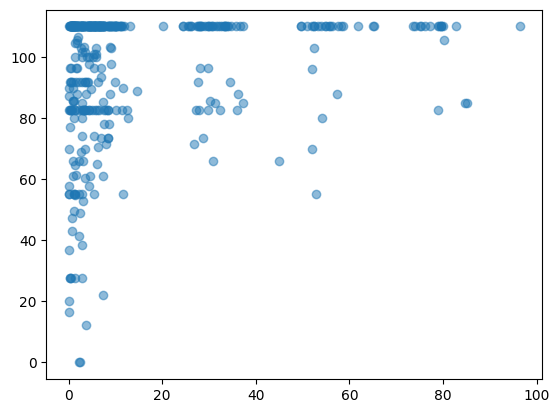

In [10]:
out = np.where((df.Tiempo <= 0) | (df.Tiempo >= 100))[0]
df.drop(out, axis=0, inplace=True)
plt.scatter(df['Tiempo'], df['Calificacion'], alpha=0.5)

Gracias a estas modificaciones a la base de datos, ahora se puede apreciar la gráfica con mayor claridad. Igualmente se podría decir que es muy poco probable que los datos tengan una relación lineal.

2. Separa los datos en entrenamiento y prueba, con una relación de 70/30. Imprime en consola el promedio de los tiempos en el conjunto de entrenamiento y en el conjunto de prueba. Haz lo mismo para las calificaciones. Incluye una línea de texto donde comentes sobre la similitud o diferencia de los valores promedio entre el conjunto de entrenamiento y el de validación, y cómo es que esto podría afectar al análisis.

In [11]:
x = df[['Tiempo']]
y = df['Calificacion']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print('Promedio de Tiempo en los datos de entrenamiento: ', x_train.mean())
print('Promedio de Tiempo en los datos de validación: ', x_test.mean())
print('Promedio de Calificacion en los datos de entrenamiento: ', y_train.mean())
print('Promedio de Calificaion en los datos de validación: ', y_test.mean())

Promedio de Tiempo en los datos de entrenamiento:  Tiempo    14.040686
dtype: float64
Promedio de Tiempo en los datos de validación:  Tiempo    14.74109
dtype: float64
Promedio de Calificacion en los datos de entrenamiento:  96.43160141843973
Promedio de Calificaion en los datos de validación:  95.78661694214877


Observando la información anterior, se puede ver que el promedio entre los datos de prueba y los datos de validación para ambas variables es muy similar, con diferencia de apenas decimas.

3. Entrena un modelo de regresión polinomial usando los datos de entrenamiento; puedes usar el orden de polinomial que consideres más adecuado. Imprime un resumen de los resultados obtenidos y agrega una línea de texto en la que comentes sobre el tipo de relación (positiva o negativa; ¿a menor tiempo menor calificación?) entre el término lineal y la respuesta, lo que esto significa y si dicha variable está significativamente asociada con las calificaciones.

In [13]:
# Aplicar transformación polinomial de grado 2
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train)
# Convertir a DataFrame con nombres de columnas adecuados
x_train_poly_df = pd.DataFrame(x_train_poly, columns=poly.get_feature_names_out(['Tiempo']))
x_train_poly_df.reset_index(drop=True, inplace=True)
y_train = y_train.reset_index(drop=True)
# Agregar una columna de constantes para la regresión
x_train_poly_df = sm.add_constant(x_train_poly_df)
# Crear y entrenar el modelo con statsmodels
model = sm.OLS(y_train, x_train_poly_df).fit()
# Mostrar el resumen del modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Calificacion   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     5.132
Date:                Thu, 13 Feb 2025   Prob (F-statistic):            0.00648
Time:                        14:30:14   Log-Likelihood:                -1253.4
No. Observations:                 282   AIC:                             2513.
Df Residuals:                     279   BIC:                             2524.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.4861      1.813     51.010      0.0

Este modelo no tiene sentido. Se puede ver claramente al analizar la R^2 que es de menos del 0.05, lo cuál inidica en realidad que este modelo explica un 3% de los datos que se usaron para entrenarlo. Además de esto, al subir el grado es muy poco probable que el modelo mejor mucho y al agregar más grados es probable también que se encuentren problemas de multicolinealidad.

4. Entrena un modelo de regresión segmentada, siguiendo la misma estrategia utilizada en la lectura interactiva, utilizando regresiones cuadráticas para cada segmento. Genera estimaciones (predicciones) en los datos de validación. Asegúrate de usar la función descrita en la lectura interactiva, instalándola en tu ambiente de trabajo en caso de no haberlo hecho previamente.

In [27]:
Xtemp_train = x_train.values.reshape(-1,1)
Xtemp_test = x_test.values.reshape(-1,1)
polyq_train = PolynomialFeatures(degree=2).fit(Xtemp_train)
polyq_test = PolynomialFeatures(degree=2).fit(Xtemp_test)
xq_train = pd.DataFrame(polyq_train.transform(Xtemp_train))
xq_test = pd.DataFrame(polyq_test.transform(Xtemp_test))
ms = PiecewiseRegressor('bins').fit(xq_train.iloc[:,1:],y_train)
yHat_ms = ms.predict(xq_test.iloc[:,1:])
RSS_ms = sum((list(y_test)-yHat_ms)**2)
RSE_ms = np.sqrt(RSS_ms/(len(y_test)-1))
print(RSE_ms)

21.214278677213578


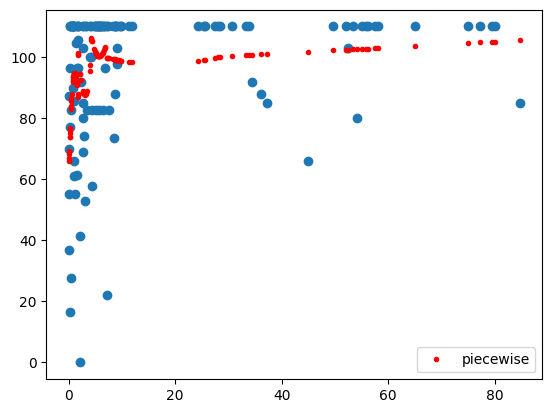

In [28]:
plt.scatter(x_test,y_test)
plt.plot(x_test,yHat_ms,"r.",label="piecewise")
plt.legend()

El modelo parece estar haciendo un trabajo regular, algunos puntos se encuentarn sobre los originales, pero la mayoría estan bastante lejos.

5. Entrena un modelo KNN para regresión utilizando el valor de k que consideres adecuado (o prueba con varios). Genera estimaciones en los datos de validación.

In [30]:
mk = KNN(n_neighbors=15).fit(Xtemp_train,y_train)
yHat_mk = mk.predict(Xtemp_test)
RSS_mk = sum((list(y_test)-yHat_mk)**2)
RSE_mk = np.sqrt(RSS_mk/(len(y_test)-1))
print(RSE_mk)

21.149867931171613


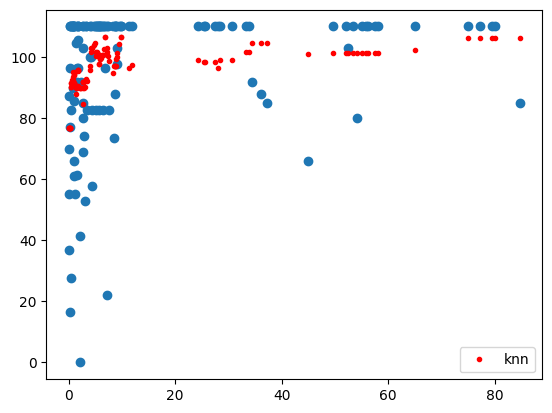

In [31]:
plt.scatter(x_test,y_test)
plt.plot(x_test,yHat_mk,"r.",label="knn")
plt.legend()

Este modelo realiza un trabajo muy similar al modelo segmentado. No es un buen trabajo, pero tampoco un terrible trabajo. Esto nos dice que los modelos no son el problema, sino los datos, que parecerían no tener una relación que pueda ser predicha con los tres modelos probados.

6. Calcula el RSE en los datos de prueba para los 3 modelos y agrega una línea de texto donde comentes sobre sus diferencias y si hay un claro “ganador”. No te bases exclusivamente en el error, puedes considerar también aspectos como la interpretabilidad del modelo.

Anteriormente se calcularon los RSE de los modelos, y el mejor fue el modelo de segmentación por un par de décimas, esto quiere decir que, aunque no es el mejor en predecir o explicar los datos en la base de datos, es el mejor de los tres que se implementaron.

*"Doy mi palabra de que he realizado esta catividad con integridad académica.*